In [1]:
#######################################################################
#
# Name: Hussein Nagree
# Course: Introduction to Connectomics, Spring 2016
# Description: This ipython notebook reads in from an ImageJ dataset
#              consisting of timeseries of mouse brain neuron activity.
#              It also reads in a labeling of neurons in these images,
#              and learns the neuron labeling to automate that process
#              in any similar sized brain scan.
#
#######################################################################

In [2]:
#######################################################################
#
# Code to read in tif files and neuron labelings, given the filenames.
#
# load_stacks takes in the tif file, and returns a 3D numpy array of 
# time*xdimension*ydimension
#
# load_rois takes in a zip file containing rois, width and height
# (usually 512*512 for the images given), as well as optional args
# for fill, x displacement, and y displacement (by default 1, 0, 0).
# It returns a numpy array of 0-1 matrices, where each matrix holds 1
# roi. An roi is visible as a roughly sphere-shaped area, usually 
# between 100 - 350 pixels, of 1s. The rest of each 512*512 matrix
# is 0s
#
#######################################################################


from PIL import Image, ImageDraw
import numpy as np

# https://gist.github.com/luispedro/3437255
# Copyright: Luis Pedro Coelho <luis@luispedro.org>, 2012
# License: MIT

def read_roi(fileobj):
# This is based on:
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiDecoder.java.html
# http://rsbweb.nih.gov/ij/developer/source/ij/io/RoiEncoder.java.html


    SPLINE_FIT = 1
    DOUBLE_HEADED = 2
    OUTLINE = 4
    OVERLAY_LABELS = 8
    OVERLAY_NAMES = 16
    OVERLAY_BACKGROUNDS = 32
    OVERLAY_BOLD = 64
    SUB_PIXEL_RESOLUTION = 128
    DRAW_OFFSET = 256


    pos = [4]
    def get8():
        pos[0] += 1
        s = fileobj.read(1)
        if not s:
            raise IOError('readroi: Unexpected EOF')
        return ord(s)

    def get16():
        b0 = get8()
        b1 = get8()
        return (b0 << 8) | b1

    def get32():
        s0 = get16()
        s1 = get16()
        return (s0 << 16) | s1

    def getfloat():
        v = np.int32(get32())
        return v.view(np.float32)

    magic = fileobj.read(4)
    if magic != b'Iout':
        raise IOError('Magic number not found. Value = ' + str(magic))
    version = get16()

    # It seems that the roi type field occupies 2 Bytes, but only one is used
    roi_type = get8()
    # Discard second Byte:
    get8()

    if not (0 <= roi_type < 11):
        raise ValueError('roireader: ROI type %s not supported' % roi_type)

    if roi_type != 7:
        raise ValueError('roireader: ROI type %s not supported (!= 7)' % roi_type)

    top = get16()
    left = get16()
    bottom = get16()
    right = get16()
    n_coordinates = get16()

    x1 = getfloat() 
    y1 = getfloat() 
    x2 = getfloat() 
    y2 = getfloat()
    stroke_width = get16()
    shape_roi_size = get32()
    stroke_color = get32()
    fill_color = get32()
    subtype = get16()
    if subtype != 0:
        raise ValueError('roireader: ROI subtype %s not supported (!= 0)' % subtype)
    options = get16()
    arrow_style = get8()
    arrow_head_size = get8()
    rect_arc_size = get16()
    position = get32()
    header2offset = get32()

    if options & SUB_PIXEL_RESOLUTION:
        getc = getfloat
        points = np.empty((n_coordinates, 2), dtype=np.float32)
    else:
        getc = get16
        points = np.empty((n_coordinates, 2), dtype=np.int16)
    points[:,1] = [getc() for i in range(n_coordinates)]
    points[:,0] = [getc() for i in range(n_coordinates)]
    points[:,1] += left
    points[:,0] += top
    points -= 1
    return points

def read_roi_zip(fname):
    import zipfile
    zf = zipfile.ZipFile(fname)
    x = []
    for n in zf.namelist():
        x.append(read_roi(zf.open(n)))
    zf.close()
    return x
    
# tif -> (time,w,h)
def load_stacks(path):
    im = Image.open(path)
    stk = []
    while True:
        stk.append(np.array(im))
        try:
            im.seek(len(stk))
        except EOFError:
            break
    return np.array(stk, dtype='float32')

# roi zip -> (index,w,h)
def load_roi(path, width, height, fill=1, xdisp=0, ydisp=0):
    rois = read_roi_zip(path)
    ret = []
    for i,roi in enumerate(rois):
        poly = []
        for x in roi:
            poly.append((x[1],x[0]))
        img = Image.new('L', (width, height), 0)
        ImageDraw.Draw(img).polygon(poly, outline=1, fill=fill)
        ret.append(np.array(img))
    return np.array(ret,dtype='float32')


In [3]:
#######################################################################
#
# Set up the variables that store all the data.
#
# files contains an array of tuples of (tif_file, zip_file). It assumes
# that all the files are stored in a directory called data, with each
# file named 'AMG[1-3]_exp[1-4].[tif/zip]', as mentioned in the dataset
# given to us by Jan
#
# data is an array of (stacks, rois) corresponding to (tif, zip) files.
# Each stack and roi is loaded using load_stacks and load_roi, and is
# a 3D array of size (num_frames/num_rois)*512*512
#
# Takes about 30s to run.
#
#######################################################################

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import laplace
from skimage import feature

plt.rcParams['figure.figsize'] = (16, 16)

# generate filenames
files = []
for i in range(1,4):
    for j in range(1,5):
        prefix = 'data/AMG%d_exp%d'%(i,j)
        files.append( (prefix+'.tif', prefix+'.zip') )
        
# load data
data = []
for i,(s,r) in enumerate(files):
    if i==8: # lolwtf
        data.append((load_stacks(s), load_roi(r, 512, 512, xdisp=9, ydisp=-1)))
    else:
        data.append((load_stacks(s), load_roi(r, 512, 512)))


In [ ]:
#######################################################################
#
# OPTIONAL: View some sample rois in tiles individually
#
#######################################################################

def NormalizeTile(tile):
    return (tile - tile.mean()) / tile.std()

w,h = [], []
tiles = []
Ztiles = []
r = 10

for stk, rois in data:
    M = stk.max(axis=0)
    for roi in rois:
        x,y = np.where(roi!=0)
        x,y = int(x.mean()), int(y.mean()) # compute centroid of roi
        if x-r>=0 and y-r>=0 and x+r<512 and y+r<512:
            tiles.append(M[x-r:x+r, y-r:y+r]) # grab tile
            Ztiles.append(NormalizeTile(M[x-r:x+r, y-r:y+r])) # grab z-scored tile
            
tiles = np.array(tiles)
Ztiles = np.array(Ztiles)

# render tiled image
Q = np.zeros((2*r*10, 2*r*10))
for i in range(10):
    for j in range(10):
        Q[2*r*i:2*r*(i+1),2*r*j:2*r*(j+1)] = Ztiles[10*i + j]

plt.imshow(Q,cmap='gray')


In [ ]:
#######################################################################
#
# OPTIONAL: View the training set. Each roi is overlaid in blue over
# the neurons. Each pixel is calculated as its (max - std dev) over
# time in the stack.
#
#######################################################################

# Pick one set
stk,rois = data[0]

# Show image of the data set
M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1)
M**=0.5

R = rois.max(axis=0) 

K = np.zeros((512,512,3))
K[:,:,0] = K[:,:,1] = K[:,:,2] = M
#K[:,:,2] = np.maximum(M,R)

plt.imshow(K)


In [4]:
#######################################################################
#
# Preprocess the rois in the training set. Make sure that old_rois is
# picked from the correct set. Since the algorithm is a sliding window
# to decide if the pixel at the center of the window is in a neuron
# nucleus, the preprocessing shrinks each roi to try and exclude the
# cell bodies. By removing the boundary pixels in each roi, it
# effectively reduces the size of each roi by 20% - 25%.
#
# Takes about 2 mins.
#
#######################################################################

# Select the training dataset
stk,rois = data[0]

# Trim the rois, but don't actually change the original values in case
# they need to be reused.
rois = np.array(rois)

dimensions = 512
# for roi in rois:
#     # Mark the border pixels to be set to 0 
#     for i in range(0, dimensions):
#         for j in range(0, dimensions):
#             if roi[i,j] == 1:
#                 if i > 0 and roi[i-1,j] == 0:
#                     roi[i, j] = 2
#                 elif j > 0 and roi[i, j-1] == 0:
#                     roi[i, j] = 2
#                 elif i < dimensions - 1 and roi[i+1, j] == 0:
#                     roi[i, j] = 2
#                 elif j < dimensions - 1 and roi[i, j+1] == 0:
#                     roi[i, j] = 2

#     for i in range(0,dimensions):
#         for j in range(0,dimensions):
#             if roi[i,j] == 2:
#                 roi[i,j] = 0


In [137]:
#######################################################################
#
# Train an SVM. Use the preprocessed rois from the previous segment,
# and slightly process the input stacks. Convert the image into an
# array of feature vectors (formed from the sliding window around each
# pixel), and the rois into an array of 0-1 values corresponding to
# whether the pixel is in the nucleus of the neuron or not. Use the
# python SVC class. 
#
# Takes 7-8 minutes
#
#######################################################################

from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.decomposition import PCA



# The radius of the sliding window
radius = 10

# The pixels skipped by the sliding window in each step
# (moving one pixel at a time is unnecessary since the window won't
# change much)
skip = 2

# The height and width (in pixels) of the input image
dimensions = 512

# The number of pixels to skip at the image boundaries 
# (since the edges tend to be mostly black)
edge = 20

# Take in a 2D square matrix of the 2*radius pixels around a pixel,
# and return a 1D array of features that have been extracted out of it.
def ExtractFeatures(tile):
    mid = tile[radius, radius]
    near = 4
    tile -= mid
    if tile.mean() != 0:
        tile = tile/tile.mean()
    return tile.flatten()

X = []
Y = []
PCA_X = []

for i in range(0,8,2):
    # Select the training dataset
    stk,rois = data[i]

    # Slight preprocessing of the image. Each pixel is maximised over time,
    # in order to increase brightness. Then, each pixel's std dev is subtracted,
    # to increase contrast between nucleuses and cell bodies (which tend to have
    # different variations in brightness over time). This is then adjusted to a
    # (0, 1) range.
    M = stk.max(axis=0) - stk.std(axis=0)
    M = np.clip((M-900)/400, 0, 1)
    M**=0.5

    # Overlay all the rois into a single matrix
    R = rois.max(axis=0) 

    # Grab the appropriate parts of the training and label data
    # Do PCA extraction for sliding windows at or near the rois.
    for i in range(edge, dimensions-edge, skip):
        for j in range(edge, dimensions-edge, skip):
            if np.sum(R[i-radius:i+radius, j-radius:j+radius]) > 10:
                tile = np.array(M[i-radius:i+radius, j-radius:j+radius])
                PCA_X.append(ExtractFeatures(tile))
                Y.append(R[i,j])

print("Size of training set: " + str(len(Y)))
print("Total positive examples: " + str(np.sum(np.array(Y))))
print("Total windows considered: " + str((((dimensions-2*edge)/skip)**2)*8))
pca = PCA(n_components=20)
X = pca.fit_transform(PCA_X)
print(np.sum(np.array(pca.explained_variance_ratio_)))

# Train the SVM using an rbf kernel
# clf = SVC()
# clf.fit(X,Y)


Size of training set: 80759
Total positive examples: 30393.0
Total windows considered: 445568.0
0.999018256537


In [138]:
clf = LinearSVC(dual=False)
clf.fit(X, Y)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [ ]:
#######################################################################
#
# OPTIONAL: Validate on another dataset. Not too useful though, since
# the large number of true negatives (non-neuron spots) make the
# accuracy appear relatively large, even if the actual labeling of
# neurons is not that accurate.
#
#######################################################################

# Select the validation dataset
(stk, rois) = data[1]

M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1 )
M**=0.5

R = rois.max(axis=0) 

YValidate = R[radius:dimensions-radius, radius:dimensions-radius].flatten()

XValidate = []
for i in range(radius, dimensions-radius):
    for j in range(radius, dimensions-radius):
        tile = np.array(M[i-radius:i+radius, j-radius:j+radius])
        XValidate.append(ExtractFeatures(tile))
        
print(clf.score(XValidate, YValidate))


In [139]:
#######################################################################
#
# Test the SVM. Print the classification accuracy, as well as the total
# recall and precision of predicting positive results (pixels that are
# in a neuron). NOTE: This is not the final precisions and accuracy, as
# the agglomeration of pixels into rois will affect these values.
#
# Takes about 30 minutes. :-(
#
#######################################################################

# Select the test dataset
(stk, rois) = data[1]

M = stk.max(axis=0) - stk.std(axis=0)
M = np.clip((M-900)/400, 0, 1 )
M**=0.5

R = rois.max(axis=0) 

YReal = R[radius:dimensions-radius, radius:dimensions-radius].flatten()

PCA_XTest = []
for i in range(radius, dimensions-radius):
    for j in range(radius, dimensions-radius):
        tile = np.array(M[i-radius:i+radius, j-radius:j+radius])
        PCA_XTest.append(ExtractFeatures(tile))
        
XTest = pca.transform(PCA_XTest)
YTest = clf.predict(XTest)

truepos = 0
falseneg = 0
falsepos = 0
count = 0
total = (dimensions-2*radius)**2

# Compare YReal (the actual labels) to YTest (our predicted labels)
for i in range(total):
    if YReal[i] == YTest[i]:
        count += 1
        if YTest[i] == 1:
            truepos += 1
    else:
        if YTest[i] == 1:
            falsepos += 1
        else:
            falseneg += 1

print("Recall: " + str(truepos/(truepos + falseneg)))
print("Precision: " + str(truepos/(truepos + falsepos)))
print("Accuracy: " + str(count/total))


Recall: 0.005389692969175801
Precision: 0.17365853658536584
Accuracy: 0.8608012756956838


True pos stats: 
Size: 4249
Max: 1.0
Min: 0.166991
Avg: 0.755275
Std: 0.233325

False pos stats: 
Size: 5322
Max: 1.0
Min: 0.150451
Avg: 0.553778
Std: 0.232175

False neg stats: 
Size: 25397
Max: 1.0
Min: 0.0
Avg: 0.576401
Std: 0.150314

Trues less than 0.15: 0
Falses less than 0.15: 0


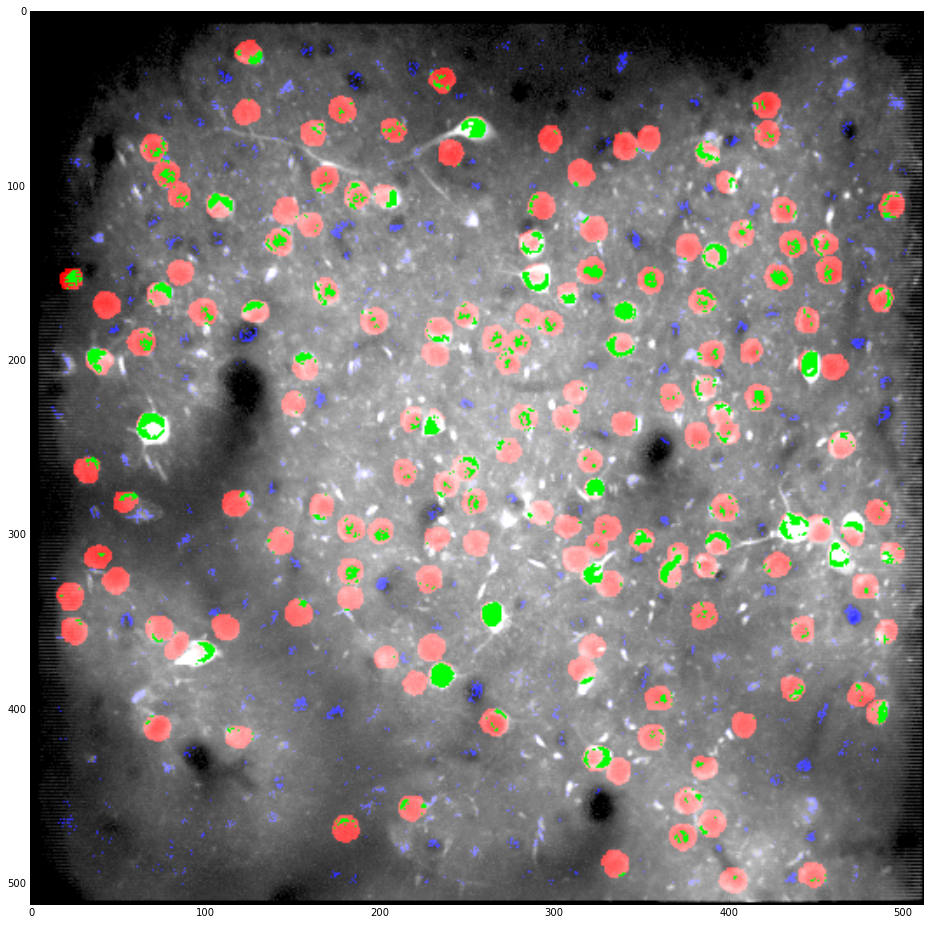

In [95]:
#######################################################################
#
# Convert YTest into 2D data, visualize the raw output, and collect
# statistics about the various pixel definitions.
#
#######################################################################

# Convert YTest back into a 2D matrix
out_pixels = np.zeros((dimensions, dimensions))
out_pixels[radius:dimensions-radius, radius:dimensions-radius] = np.reshape(YTest, (-1, dimensions-2*radius))

# False negatives occur at blood vessels a lot, however blood vessels usually correspond to 
# lower pixel values than neurons. We can get rid of a lot of false positives, while losing
# very few true positives, by setting a thershold for the minimum pixel brightness of a 
# true positive
true_positive_brightness = 0.15

out_pixels[np.where(M < true_positive_brightness)] = 0
K = np.zeros((512,512,3))
K[:,:,1] = M
K[:,:,0] = np.maximum(M, R)
K[:,:,2] = np.maximum(M, out_pixels)
false_pos = []
true_pos = []
false_neg = []

for i in range(dimensions):
    for j in range(dimensions):
        if R[i,j] == 1 and out_pixels[i,j] == 1:
            K[i,j,0] = 0
            K[i,j,1] = out_pixels[i,j]
            K[i,j,2] = 0
            true_pos.append(M[i,j])
        elif R[i,j] == 0 and out_pixels[i,j] == 1:
            false_pos.append(M[i,j])
        elif R[i,j] == 1:
            false_neg.append(M[i,j])

print("True pos stats: ")
print("Size: " + str(np.size(true_pos)))
print("Max: " + str(np.max(true_pos)))
print("Min: " + str(np.min(true_pos)))
print("Avg: " + str(np.mean(true_pos)))
print("Std: " + str(np.std(true_pos)))

print("\nFalse pos stats: ")
print("Size: " + str(np.size(false_pos)))
print("Max: " + str(np.max(false_pos)))
print("Min: " + str(np.min(false_pos)))
print("Avg: " + str(np.mean(false_pos)))
print("Std: " + str(np.std(false_pos)))

print("\nFalse neg stats: ")
print("Size: " + str(np.size(false_neg)))
print("Max: " + str(np.max(false_neg)))
print("Min: " + str(np.min(false_neg)))
print("Avg: " + str(np.mean(false_neg)))
print("Std: " + str(np.std(false_neg)))
            
plt.imshow(K)

In [96]:
#######################################################################
#
# Agglomerate and separate neuron regions into individual rois, stored
# in the array out_rois. This is in the same format as the input rois
# when read in by load_roi.
#
#######################################################################

# Array of rois to return
out_rois = []

out_pixels_cpy = np.array(out_pixels)

# Returns probability that a box of size 2*r in out_pixels centered on (i, j) contains a neuron
def NeuronProb(i, j, r):
    return np.sum(out_pixels[i-r:i+r, j-r:j+r])/((2*r)**2)

# Adds an roi centered around i,j to out_rois, and removes it from out_pixels
def AddRoi(i, j):
    # Minimum, maximum radius of the potential roi
    r = 8
    # Add new roi
    patch = np.zeros((dimensions, dimensions))
    # Make it a sphere
    for x in range(0, 2*r):
        for y in range(0, 2*r):
            if (r-x)**2 + (r-y)**2 <= r*r:
                patch[i-r+x, j-r+y] = 1
    out_rois.append(patch)
    # Remove 1s from that region
    out_pixels[np.where(patch == 1)] = 0

# Make radius more conservative when grouping neurons.
# The average neuron is about 150-200 pixels, so a circular neuron of
# radius 8 should encompass most of a typical neuron. 
rad = 8

# Threshold can be used to adjust the precision vs accuracy. Higher threshold
# leads to high precision but lower accuracy. 
threshold = 0.15

# Extract rois
for i in range(rad, dimensions-rad-1):
    for j in range(rad, dimensions-rad-1):
        prob = NeuronProb(i, j, rad)
        # Check right and bottom for continuation of same neuron
        if prob > threshold and prob > NeuronProb(i, j+1, rad) and prob > NeuronProb(i+1, j, rad):
            AddRoi(i,j)
            

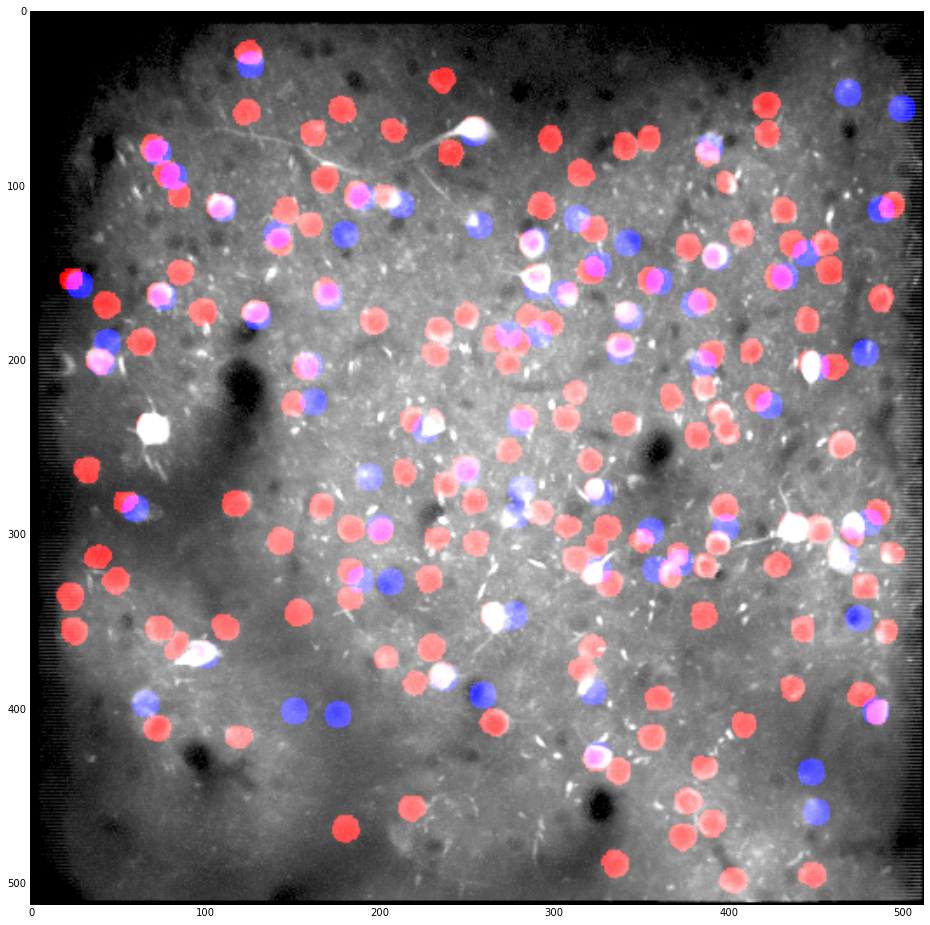

In [97]:
# View overlaid rois

K[:,:,0] = K[:,:,1] = K[:,:,2] = M
K[:,:,0] = np.maximum(M, R)
K[:,:,2] = np.maximum(M, np.array(out_rois).max(axis=0))
plt.imshow(K)

In [99]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import random

class TestSet: 
    """Stores test set or validation set data and images.
    
    self.data   = list of 3D image arrays with dimensions (stack, time, w, h)
    self.labels = list of 3D ROI arrays with dimensions (stack, ROI index, w, h)
    Change code so "files" points to the test/validation set
    """
    def __init__(self):
        files = []
        for j in range(3,5):
            prefix = 'data/AMG3_exp%d'%(j)
            files.append( (prefix+'.tif', prefix+'.zip') )
        self.data = []
        self.labels = []
        for i,(s,r) in enumerate(files):
            self.data.append(load_stack(s))
            self.labels.append(load_rois(r, 512, 512))

class Score:
    """Class to calculate and store score.
    
    Constructor takes a prediction function that takes a list of image stacks and 
    returns a list of 3D 0-1 ROI arrays with dimensions (stack, roi index, w, h).
    
    self.predictions      = list of predicted ROIs (stack, ROI index, w, h)
    self.categorized      = list of predicted ROIs divided into FPs, FNs, and TPs matched with true ROIs
                             pred ROIs with <0.5 overlap to any true ROI are false positives
                             true ROIs with <0.5 overlap to any pred ROI are false negatives
                             true positive pairs are made by maximizing overlap between pairs
                             e.g. self.categorized[0]["fps"][n] = nth false positive ROI from the 0th image stack
                             e.g. self.categorized[0]["tps"][n] = nth (pred ROI, true ROI) pair from 0th image stack
    self.total_f1_score   = F1 score with all image stacks merged
    self.f1_scores        = list of F1 scores per stack
    self.total_precision  = total precision with all image stacks merged
    self.precisions       = list of precisions per stack
    self.total_recall     = total recall with all stacks merged
    self.recalls          = list of recalls per stack
    self.total_overlap_bq = dict of pixel-wise precisions and recalls for all paired TP predicted ROIs and true ROIs
                            keys = ["mean precision", "std precision", "mean recall", "std recall"]
                             e.g. self.total_overlap_bq["mean precision"] = 
                               mean (pixels in both pred_roi and true_roi) / (pixels in pred_roi)
    self.overlap_bqs      = list of dicts as in self.total_overlap_bq with one dict per image stack                   
    """
    def __init__(self, prediction_func, data, actual_labels, predicted_labels=None):
        if predicted_labels is None:
            self.predictions = prediction_func(data)
        else:
            self.predictions = predicted_labels
        # assert that predicted and true ROI stacks are the same shape
        assert(self.predictions[0].shape[1] == actual_labels[0].shape[1])
        # assert that predicted ROI stacks are 0-1 arrays
        for i in range(len(self.predictions)):
            assert(np.all(np.logical_or(self.predictions[i] == 1, self.predictions[i] == 0)))
        self.categorized = categorize(self.predictions, actual_labels)
        self.precisions, self.total_precision, self.recalls, self.total_recall = calc_precision_recall(self.categorized)
        self.f1_scores = list(map(calc_f1_score, zip(self.precisions, self.recalls)))
        self.total_f1_score = calc_f1_score((self.total_precision, self.total_recall))
        self.overlap_bqs, self.total_overlap_bq = overlap_boundary_quality(self.categorized)
       
    def __str__(self):
        """Convert Score to readable output"""
        string =  "Total F1 Score      = {}\n".format(self.total_f1_score)
        string += "F1 Score per stack  = {!s}\n".format(self.f1_scores)
        string += "Total Precision     = {}\n".format(self.total_precision)
        string += "Precision per stack = {!s}\n".format(self.precisions)
        string += "Total Recall        = {}\n".format(self.total_recall)
        string += "Recall per stack    = {!s}\n".format(self.recalls)
        string += "Overlap Boundary Quality, all stacks = {!s}\n".format(self.total_overlap_bq)
        string += "Overlap Boundary Quality, per stack  = {!s}\n\n".format(self.overlap_bqs)
        return string
    
    def plot(self):
        """Plot all data in Score"""
        fig, ax = plt.subplots()
        yvals = [self.total_f1_score, self.total_precision, self.total_recall, 
                self.total_overlap_bq["mean precision"], self.total_overlap_bq["std precision"],
                self.total_overlap_bq["mean recall"], self.total_overlap_bq["std recall"]]
        xvals = np.arange(len(yvals))
        plt.bar(xvals, yvals, width=0.6)
        ax.set_xticks(xvals + 0.3)
        ax.set_xticklabels(['F1 score', 'precision', 'recall', 'mbp', 'sbp', 'mbr', 'sbr'])
        plt.show()
        
def categorize(predictions, labels):
    "Divide predictions and labels into FPs, FNs, and TPs"
    categorized = []
    rois_pred, rois_true = list(predictions.copy()), list(labels.copy())
    categorized.append({"fps":[], "fns":[], "tps":[]})
    for roi_pred in rois_pred:
        overlaps = list(map(lambda roi_true: calc_overlap(roi_pred, roi_true)[0], rois_true))
        best_overlap, best_index = np.max(overlaps), np.argmax(overlaps)
        if best_overlap > 0.5:
            categorized[0]["tps"].append((roi_pred, rois_true[best_index]))
            del rois_true[best_index]
        else:
            categorized[0]["fps"].append(roi_pred)
    for roi_true in rois_true:
        categorized[0]["fns"].append(roi_true)
    return categorized

def calc_precision_recall(categorized):
    """Calculate precision and recall from categorized predictions and labels"""
    num_fps = [len(categorized[i]["fps"]) for i in range(len(categorized))]
    num_fns = [len(categorized[i]["fns"]) for i in range(len(categorized))]
    num_pairs = [len(categorized[i]["tps"]) for i in range(len(categorized))]
    precisions = [num_pairs[i] / float(num_pairs[i] + num_fps[i]) for i in range(len(categorized))]
    recalls = [num_pairs[i] / float(num_pairs[i] + num_fns[i]) for i in range(len(categorized))]
    total_precision = sum(num_pairs) / float(sum(num_pairs) + sum(num_fps))
    total_recall = sum(num_pairs) / float(sum(num_pairs) + sum(num_fns))
    return precisions, total_precision, recalls, total_recall
    
def calc_overlap(roi_pred, roi_true):
    """For a given (2D array, 2D array) pair of predicted and true ROIs,
    overlap   = (# pixel intersection / (# pixel union)
    precision = (# pixel intersection) / (# pixels in true ROI)
    recall    = (# pixel interection) / (# pixels in pred ROI)
    """

    intersection = float(np.dot(roi_pred.flat, roi_true.flat))
    
    if intersection == 0: 
        return 0, 0, 0
    
    pred = np.sum(roi_pred)
    true = np.sum(roi_true)
    union = pred + true - intersection
    
    precision = intersection / pred
    recall = intersection / true
    overlap = intersection / union
    return overlap, precision, recall

def calc_f1_score(pr):
    """F1 score is harmonic mean of precision and recall"""
    precision, recall = pr
    if recall == 0:
        return 0 
    else:
        return (2 * precision * recall) / (precision + recall)
    
def overlap_boundary_quality(categorized):
    """Calculates pixel-based mean and std of precision and recall 
    of TP (pred roi, true roi) pairs
    """
    qualities = []
    precisions = []
    recalls = []
    for i in range(len(categorized)):
        precisions.append([])
        recalls.append([])
        for roi_pred, roi_true in categorized[i]["tps"]:
            _, precision, recall = calc_overlap(roi_pred, roi_true)
            precisions[i].append(precision)
            recalls[i].append(recall)
        qualities.append({"mean precision": np.mean(precisions[i]), "std precision": np.std(precisions[i]),
                          "mean recall": np.mean(recalls[i]), "std recall": np.std(recalls[i])})
    overall = {"mean precision": np.mean(list(chain.from_iterable(precisions))),
               "std precision": np.std(list(chain.from_iterable(precisions))),
               "mean recall": np.mean(list(chain.from_iterable(recalls))),
               "std recall": np.std(list(chain.from_iterable(recalls)))}
    return qualities, overall   

def plot_multiple_scores(scores):
    """Takes list of multiple scores and plots precision/recall curves
    and f1 score comparisons.
    """
    f1_fig, ax = plt.subplots()
    f1s = [s.total_f1_score for s in scores]
    x = np.arange(len(f1s))
    plt.bar(x, f1s, width=1)
    ax.set_xticks(x + 0.5)
    ax.set_xticklabels(map(str,x))
    plt.ylabel('F1 score')
    plt.xlabel('Algorithm Number')
    
    pr_fig = plt.figure()
    recalls = [s.total_recall for s in scores]
    precisions = [s.total_precision for s in scores]
    r, p, num = zip(*sorted(zip(recalls, precisions, np.arange(len(recalls)))))
    plt.plot(r, p, '.-', markersize=10)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    print("Score Number in order of increasing recall: " + str(num))
    
    pr_boundary_fig = plt.figure()
    recalls = [s.total_overlap_bq["mean recall"] for s in scores]
    precisions = [s.total_overlap_bq["mean precision"] for s in scores]
    r_std = [s.total_overlap_bq["std recall"] for s in scores]
    p_std = [s.total_overlap_bq["std precision"] for s in scores]
    rm, pm, rs, ps, num = zip(*sorted(zip(recalls, precisions, r_std, p_std, np.arange(len(recalls)))))
    plt.errorbar(rm, pm, xerr=rs, yerr=ps, fmt='.-',markersize=10)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    print("Score number in order of increasing boundary recall: " + str(num))
    
    plt.show()


In [100]:
score = Score(ExtractFeatures, stk, rois, np.array(out_rois))

In [101]:
print(score)

Total F1 Score      = 0.19917012448132776
F1 Score per stack  = [0.19917012448132776]
Total Precision     = 0.3116883116883117
Precision per stack = [0.3116883116883117]
Total Recall        = 0.14634146341463414
Recall per stack    = [0.14634146341463414]
Overlap Boundary Quality, all stacks = {'std recall': 0.083753093160959816, 'mean recall': 0.79819337967441717, 'std precision': 0.079565258958885665, 'mean precision': 0.73418803418803424}
Overlap Boundary Quality, per stack  = [{'std recall': 0.083753093160959816, 'mean recall': 0.79819337967441717, 'std precision': 0.079565258958885665, 'mean precision': 0.73418803418803424}]




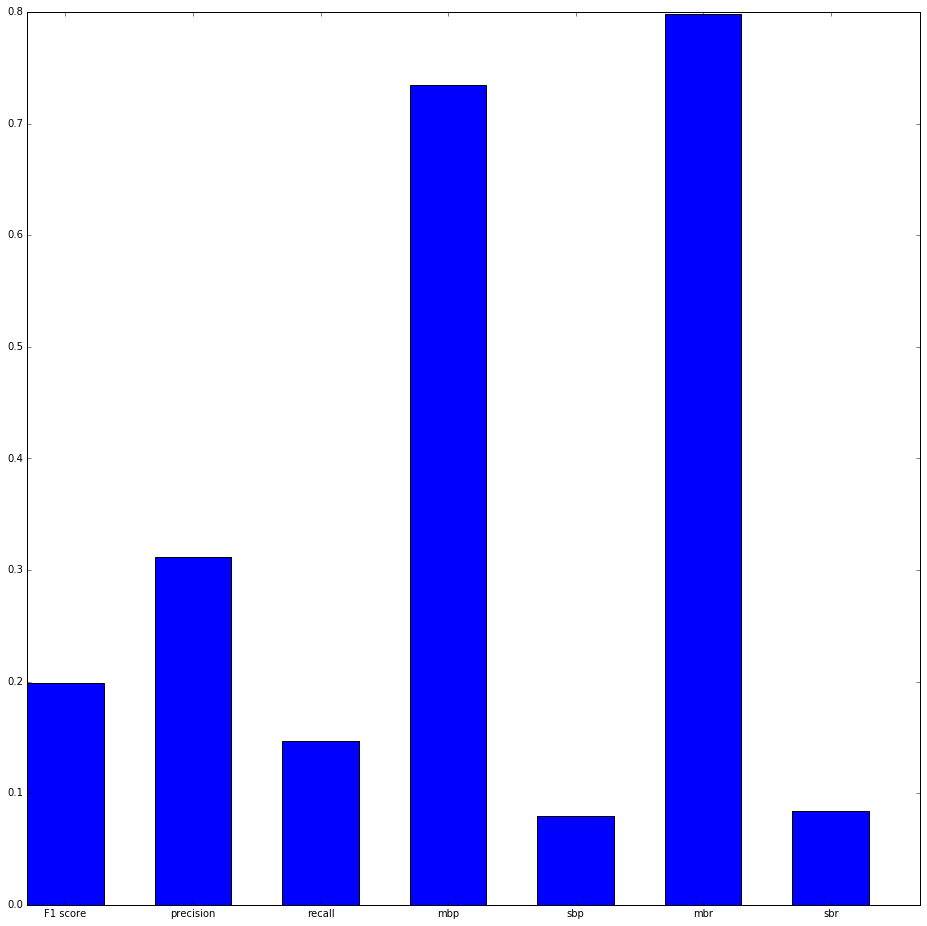

In [102]:
score.plot()